# **Veri Önişleme**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os

def create_dataframe(base_path):
    """
    PNG formatındaki balık fotoğraflarından DataFrame oluşturur.
    """
    if not base_path or not isinstance(base_path, str):
        raise ValueError("Geçerli bir klasör yolu girilmelidir.")
        
    if not os.path.exists(base_path):
        raise FileNotFoundError(f"Klasör bulunamadı: {base_path}")
        
    label = []
    path = []
    try:
        for dir_name, _,filenames in os.walk(base_path):
            for filename in filenames:
                if os.path.splitext(filename)[1]=='.png':
                    if dir_name.split()[-1]!='GT':          
                        label.append(os.path.split(dir_name)[1])
                        path.append(os.path.join(dir_name, filename))
            
        df = pd.DataFrame({'path': path, 'label': label})
        df = df.drop_duplicates()
        
        if df.isnull().any().any():
            print("Uyarı: DataFrame'de boş değerler var!")
            
        print("\nEtiket dağılımı:")
        print(df['label'].value_counts())
    
        return df
        
    except Exception as e:
        raise Exception(f"DataFrame oluşturulurken hata oluştu: {str(e)}")

try:
    data = create_dataframe('/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')
    print(f"\nToplam görüntü sayısı: {data.shape[0]}")
    print(f"Sütun sayısı: {data.shape[1]}")
except Exception as e:
    print(f"Hata: {str(e)}")


Etiket dağılımı:
label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

Toplam görüntü sayısı: 9000
Sütun sayısı: 2


Balık fotoğraflarının bulunduğu klasörü tarar

Her .png dosyası için:


    Dosya yolunu kaydeder (path)
    Balık türünü etiket olarak alır (label)
    
    
Sonuçta 2 sütunlu (path, label) bir pandas DataFrame oluşturur ve bunu döndürür.

Bu işlem, model eğitimi öncesinde veri setini organize etmek için önemli bir ön işleme adımıdır. 



In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


Verisetinde sınıfların dağılımı gözlenmek için yazıldı. 

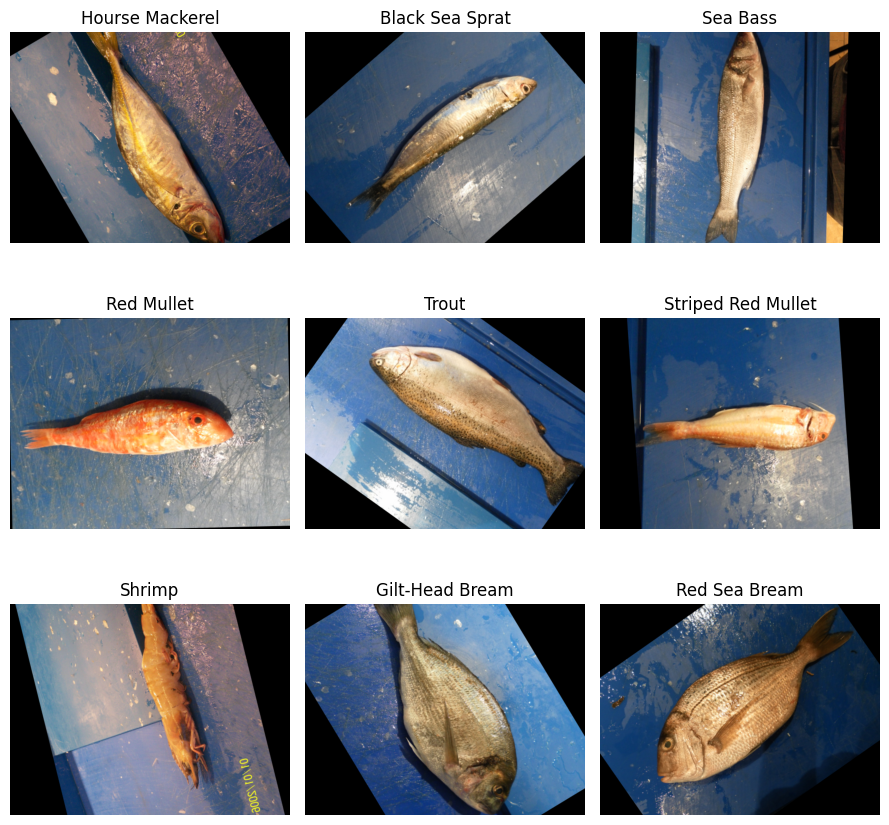

In [3]:
import matplotlib.pyplot as plt
import cv2

unique_labels = data['label'].unique()
plt.figure(figsize=(9, 9))

for i, label in enumerate(unique_labels[:]):
    sample = data[data['label'] == label].sample(1).iloc[0]
    img_path = sample['path']
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Renk uzayını düzeltelim (BGR -> RGB)

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
Her sınıftan birer örnek resim gösteren kod.

In [4]:
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def prepare_data(df, img_size=(128, 128)):
    """
    Görüntüleri tensorflow.keras.preprocessing.image kullanarak yükler ve modele hazır hale getirir
    """
    X = []
    y = []
    
    # LabelEncoder'ı oluştur
    label_encoder = LabelEncoder()
    
    # Etiketleri sayısal değerlere dönüştür
    df['label'] = label_encoder.fit_transform(df['label'])
    
    for idx, row in df.iterrows():
        # Görüntüyü yükle
        img = image.load_img(row['path'], 
                             target_size=img_size,
                             color_mode='rgb')
        
        # Görüntüyü array'e çevir
        img_array = image.img_to_array(img)
        
        # Normalize et (0-1 arasına)
        img_array = img_array / 255.0
        
        X.append(img_array)
        y.append(row['label'])
    
    # Etiketleri one-hot encode et
    y = to_categorical(y, num_classes=len(label_encoder.classes_))
    
    return np.array(X), np.array(y), label_encoder

# Veriyi hazırla
X, y, label_encoder = prepare_data(data)

# Veriyi eğitim ve test setlerine ayır
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Test-Train verisi hazırlandı.")

Test-Train verisi hazırlandı.


# **Modelin Eğitilmesi**

In [11]:
from tensorflow.keras import backend as K

# TensorFlow oturumunu sıfırlama
K.clear_session()

In [12]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten


def create_ann_model():
    """
    Balık sınıflandırma için basit bir ANN modeli
    """
    # Modeli oluşturalım
    model = Sequential()
    model.add(Flatten(input_shape=(128, 128, 3)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(9, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

# Modeli oluştur
model = create_ann_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,645,577 (48.24 MB)

 Trainable params: 12,645,577 (48.24 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

# Erken durdurma uygulamak
early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

# Modeli eğit
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,
                    batch_size=32,
                    callbacks=[early_stopping])

for epoch in range(len(history.history['loss'])):
    print(f"Epoch {epoch + 1}")

Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 37s 153ms/step - accuracy: 0.1177 - loss: 2.8948 - val_accuracy: 0.1778 - val_loss: 2.1638
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - accuracy: 0.1398 - loss: 2.1559 - val_accuracy: 0.2200 - val_loss: 2.0056
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - accuracy: 0.1972 - loss: 2.0579 - val_accuracy: 0.2389 - val_loss: 1.8827
Epoch 4/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - accuracy: 0.2098 - loss: 1.9615 - val_accuracy: 0.3328 - val_loss: 1.7348
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - accuracy: 0.2610 - loss: 1.8463 - val_accuracy: 0.3778 - val_loss: 1.6145
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 151ms/step - accuracy: 0.3027 - loss: 1.7205 - val_accuracy: 0.3972 - val_loss: 1.5644
Epoch 7/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 34s 150ms/step - accuracy: 0.3578 - loss: 1.6377 - val_accuracy: 0.4483 - val_loss: 1.4285
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 153ms/step - accuracy: 0.3972 -

# **Modelin Değerlendirilmesi**


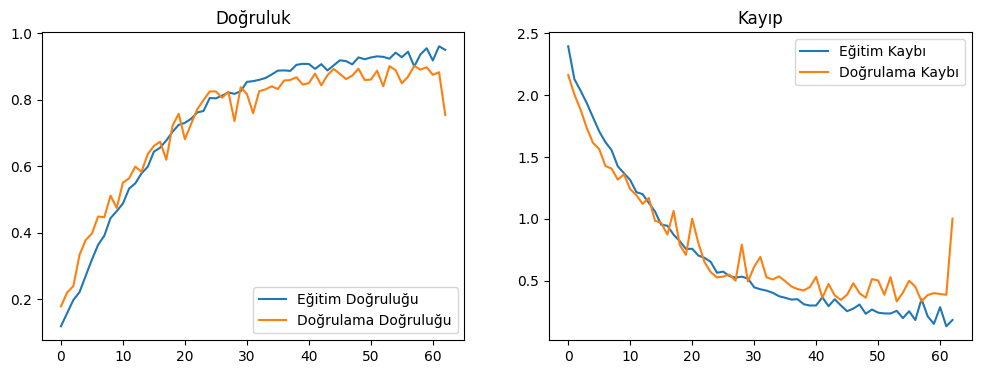

In [14]:
def visualize_metrics(history):
    
    # Eğitim sürecini görselleştirelim
    plt.figure(figsize=(12, 4))

    # Doğruluk
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
    plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
    plt.title('Doğruluk')
    plt.legend()

    # Kayıp
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Eğitim Kaybı')
    plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
    plt.title('Kayıp')
    plt.legend()

    plt.show()
    
visualize_metrics(history)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


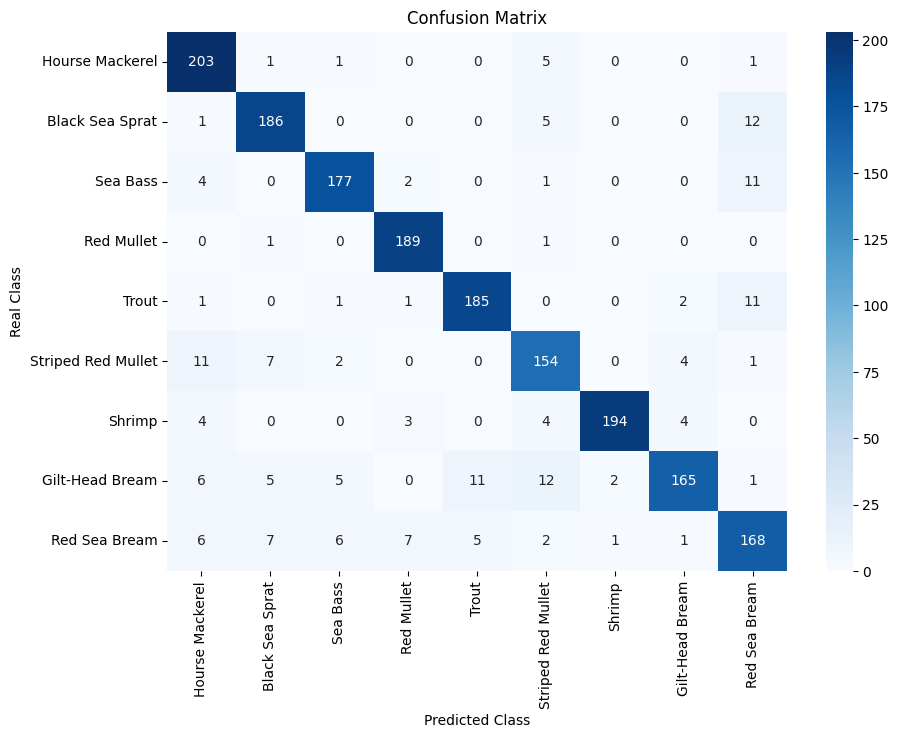

Sınıflandırma Raporu:
                     precision    recall  f1-score   support

   Hourse Mackerel       0.86      0.96      0.91       211
   Black Sea Sprat       0.90      0.91      0.91       204
          Sea Bass       0.92      0.91      0.91       195
        Red Mullet       0.94      0.99      0.96       191
             Trout       0.92      0.92      0.92       201
Striped Red Mullet       0.84      0.86      0.85       179
            Shrimp       0.98      0.93      0.96       209
   Gilt-Head Bream       0.94      0.80      0.86       207
     Red Sea Bream       0.82      0.83      0.82       203

          accuracy                           0.90      1800
         macro avg       0.90      0.90      0.90      1800
      weighted avg       0.90      0.90      0.90      1800



In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  

y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

class_names = ['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet', 'Trout', 'Striped Red Mullet', 'Shrimp','Gilt-Head Bream','Red Sea Bream']  # Sınıf isimlerinizi buraya ekleyin

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()


report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Sınıflandırma Raporu:\n", report)

Model genel olarak iyi performans gösteriyor, ancak bazı sınıflar özellikle Gilt-Head Bream ve Red Sea Bream biraz daha düşük performans sergiliyor. Bu sınıflar için model iyileştirilebilir. Öte yandan, Shrimp ve Red Mullet gibi sınıflarda model çok güçlü sonuçlar veriyor.

# **Hiperparametre Optimizasyonu**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras_tuner import Hyperband
import numpy as np

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(128, 128, 3)))
    
    # Optimize number of dense layers and their units
    for i in range(hp.Int('num_dense_layers', min_value=2, max_value=5)):
        model.add(keras.layers.Dense(
            units=hp.Int(f'dense_{i}_units', 
                        min_value=64, 
                        max_value=512, 
                        step=64),
            activation=hp.Choice(f'dense_{i}_activation', 
                               values=['relu', 'elu', 'selu'])
        ))
        
        # Add optional batch normalization
        if hp.Boolean(f'batch_norm_{i}'):
            model.add(keras.layers.BatchNormalization())
            
        # Optimize dropout rate
        model.add(keras.layers.Dropout(
            hp.Float(f'dropout_{i}', 
                    min_value=0.1, 
                    max_value=0.5, 
                    step=0.1)
        ))
    
    # Output layer
    model.add(keras.layers.Dense(9, activation='softmax'))
    
    # Optimize learning rate
    learning_rate = hp.Float('learning_rate', 
                           min_value=1e-4, 
                           max_value=1e-2, 
                           sampling='log')
    
    # Optimize optimizer
    optimizer_choice = hp.Choice('optimizer', 
                               values=['adam', 'rmsprop', 'sgd'])
    
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Hyperband optimizer
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='fish_classification'
)

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Search for best hyperparameters
tuner.search(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

# Get best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

Kaggle'a aktaramadım ancak IDE üzerinde yaptığım testlerde, elde ettiğim en iyi sonuç şudur:

Sınıflandırma Raporu:
                     precision    recall  f1-score   support

       Hourse Mackerel       0.89      0.96      0.95       211
   
       Black Sea Sprat       0.93      0.94      0.94       204
   
              Sea Bass       0.95      0.94      0.94       195
          
            Red Mullet       0.97      0.99      0.96       191
        
                 Trout       0.95      0.92      0.92       201
             
    Striped Red Mullet       0.91      0.95      0.96       179

                Shrimp       0.98      0.96      0.96       209
            
       Gilt-Head Bream       0.98      1.00      1.00       207
   
         Red Sea Bream       0.94      0.91      0.92       203

              accuracy                           0.94      1800
             macro avg       0.94      0.94      0.94      1800
          weighted avg       0.94      0.94      0.94      1800
